In [1]:
from random import random, seed
from math import floor, pi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import numpy as np
import os

In [2]:
def load_h(Nh, s_box, Nh_max):
    # Initializes the Unit Cell with H2 particles
    X = [0]*Nh_max; Y=[0]*Nh_max; Z=[0]*Nh_max;
    for i in range(Nh ):
        X[i] = random()*s_box #[A]
        Y[i] = random()*s_box #[A]
        Z[i] = random()*s_box #[A]
    return X,Y,Z   

def load_c(s_box,c_bond):
    # Initializes the Unit Cell with C particles
    Nci = floor( s_box/c_bond )
    Nc = 3*Nci
    Xc = [0]*Nc
    Yc = [0]*Nc
    Zc = [0]*Nc
    for i in range(Nci):
        Xc[i] = c_bond*i + 0.02 #[A]
        Yc[i] = s_box/2 #[A]
        Zc[i] = s_box/2 #[A]
    for j in range(Nci):
        Xc[Nci + j] = s_box/2 #[A]
        Yc[Nci + j] = c_bond*j + 0.02 #[A]
        Zc[Nci + j] = s_box/2 #[A]
    for k in range(Nci):
        Xc[2*Nci + k] = s_box/2 #[A]
        Yc[2*Nci + k] = s_box/2 #[A]
        Zc[2*Nci + k] = c_bond*k + 0.02 #[A]
    Nc = 0
    Xc=[]; Yc=[]; Zc=[]
    return Xc, Yc, Zc, Nc

def move(o, x, y, z):
    # Carry out the "move" trial move
    X[o] = x
    Y[o] = y
    Z[o] = z
def add(x, y, z):
    # Carry out the "add" trial move
    global Nh
    X[Nh] = x
    Y[Nh] = y
    Z[Nh] = z
    Nh = Nh + 1
def remove(o):
    # Carry out the "remove" trial move
    global Nh
    Nh = Nh - 1
    X[o] = X[Nh]
    Y[o] = Y[Nh]
    Z[o] = Z[Nh]
    
def get_h():
    return X[:Nh], Y[:Nh], Z[:Nh]

def dist_hi(x,y,z,j):
    # Distance btw a proposed particle and the ith H2 particle
    dx = x - X[j] #[A]
    dy = y - Y[j] #[A]
    dz = z - Z[j] #[A]
    if (dx > 0.5*s_box):
        dx = dx-s_box 
    elif (dx < -0.5*s_box):
        dx = dx + s_box
    if (dy > 0.5*s_box):
        dy = dy-s_box
    elif (dy < -0.5*s_box):
        dy = dy + s_box
    if (dz > 0.5*s_box):
        dz = dz-s_box
    elif (dz < -0.5*s_box):
        dz = dz + s_box
    return dx*dx + dy*dy + dz*dz

def dist_ci(x,y,z,j):
    # Distance btw proposed particle and the ith C particle
    dx = x - Xc[j] #[A]
    dy = y - Yc[j] #[A]
    dz = z - Zc[j] #[A]
    if (dx > 0.5*s_box):
        dx = dx-s_box
    elif (dx < -0.5*s_box):
        dx = dx + s_box
    if (dy > 0.5*s_box):
        dy = dy-s_box
    elif (dy < -0.5*s_box):
        dy = dy + s_box
    if (dz > 0.5*s_box):
        dz = dz-s_box
    elif (dz < -0.5*s_box):
        dz = dz + s_box
    return dx*dx + dy*dy + dz*dz

def dist_h(x,y,z):
    # Distance btw proposed particle and all H2 particles
    # Currently not used
    r2h = [0]*Nh 
    for i in range(Nh):
        r2h[i] = dist_hi( x,y,z,i ) #[A^2]
    return r2h

def dist_c(x,y,z):
    # Distance btw proposed particle and all C particles
    # Currently not used
    r2c = [0]*Nc
    for i in range(Nc):
        r2c[i] = dist_ci(x,y,z,i) #[A^2]
    return r2c


def Ui(r2, eps, sig):
    # LJ potential btw two particles at r distance away
    if ( r2 < rc*rc ):
        r2i = sig*sig/r2 #[]
        r6i = r2i*r2i*r2i
        En = 4*eps*(r6i*r6i-r6i) #[K]
        Vir = 48*eps*(r6i*r6i-0.5*r6i) #[K]
    else:
        En = 0
        Vir = 0
    return En, Vir

def Up( x, y, z, ia, jb=0):
    # Total LJ potential of proposed particle with all other particles
    # omit the ia'th H2 particle. When not needed, Nh is used.
    # jb used in the UTo operation to avoid overcounting interactions
    En_move = 0
    Vir_move = 0
    for i in range(jb, Nh): # H2 particles
        if ( i != ia):
            r2 = dist_hi( x,y,z, i)
            ui, viri = Ui( r2, e_hh, s_hh)
            En_move = En_move + ui
            Vir_move = Vir_move + viri
    for ic in range(Nc): # C particles
        r2 = dist_ci( x,y,z, ic)
        ui, viri = Ui( r2, e_hc, s_hc)
        En_move = En_move + ui
        Vir_move = Vir_move + viri
    return En_move, Vir_move

def p_rem( U_move ):
    # Acceptance probability of the "remove" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta < -100):
        return 1
    else:
        return Nh*kb*np.exp( -beta*U_move )/(ZZ*Vol)
    
def p_add( U_move ):
    # acceptance probability of the "add" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta > 100):
        return 1
    else:
        return ZZ*Vol*np.exp( -beta*U_move )/(Nh + 1)/kb
    
def p_move( U_move ):
    # acceptance probability of the "move" trial move 
    #     given change in LJ potential
    if (U_move*beta > 100):
        return 0
    elif (U_move*beta < -100):
        return 1
    else:
        return np.exp( -beta*U_move)

def mc_add():
    # Attempt an "add" trial move
    global UT, VirT, Nh, Aacc, Aatt
    
    Aatt = Aatt + 1
    # Select Random location
    x = random()*s_box
    y = random()*s_box
    z = random()*s_box
    
    #Calculate Energy of Trial Move
    U_move, Vir_move = Up(x,y,z,Nh+1)
    if tailcor:
        U_move = U_move + (Nh+1)*Ucor(rc,(Nh+1)/Vol) - Nh*Ucor(rc, Nh/Vol)
        
    # Probability of accepting trial move
    pa_add = p_add( U_move )
    
    # Accept or Decline the Trial move
    if (random() < pa_add):
        add(x,y,z)
        UT = UT + U_move
        VirT = VirT + Vir_move
        Aacc = Aacc + 1
        if (Nh > Nh_max):
            Panic()
            
def mc_remove():
    # Attempt a "remove" trial move
    global UT, VirT, Nh, Ratt, Racc
    Ratt = Ratt + 1
    if (Nh == 0):
        return
    
    # Select Random particle
    o = floor( random()*Nh )
    x = X[o]
    y = Y[o]
    z = Z[o]
    
    # Calculate Energy of Trial Move
    U_move, Vir_move = Up( x,y,z, o)
    U_move = -U_move
    Vir_move = -Vir_move
    if tailcor:
        U_move = U_move + ((Nh-1)*Ucor(rc,(Nh-1)/Vol)-Nh*Ucor(rc,Nh/Vol))
    
    # Probability of Accepting Trial Move
    pa_remove = p_rem( U_move )
    
    # Accept or Decline Trial Move
    if (random() < pa_remove):
        remove(o)
        UT = UT + U_move
        VirT = VirT + Vir_move
        Racc = Racc + 1
        if (Nh > Nh_max):
            Panic()
            
            
            
def mc_move():
    # Attempt a "move" trial move
    global UT, VirT, Nh, Nacc, Natt
    Natt = Natt + 1
    if (Nh == 0):
        return
    
    # Select Random particle
    o = floor( random()*Nh )
    x = X[o]
    y = Y[o]
    z = Z[o]
    
    # Calculate Energy of current configuration
    U1, V1 = Up( x,y,z, o)
    
    # Calculate new Location
    xn = x + delta*(random()-0.5)
    yn = y + delta*(random()-0.5)
    zn = z + delta*(random()-0.5)
    xn, yn, zn = box_fix( xn, yn, zn )
    
    # Calculate Energy of New Configuration
    U2, V2 = Up( xn,yn,zn, o)
    U_move = U2 - U1
    V_move = V2 - V1
    
    pa_move = p_move( U_move )
        
    # Accept the trial move
    if ( random() < pa_move ):
        Nacc = Nacc + 1
        move(o, xn, yn, zn)
        UT = UT + U_move
        VirT = VirT + V_move
    
def look():
    # Plot a bird's eye view of Unit Cell
    plt.scatter( Xc, Yc, c="k")
    Xh, Yh, Zh = get_h()
    plt.scatter( Xh, Yh, c="b")
        
def box_fix( x, y, z):
    # Correct for unit cell periodicity
    # Currently not used
    if x < 0:
        x = x + s_box
    if x > s_box:
        x = x - s_box
    if y < 0:
        y = y + s_box
    if y > s_box:
        y = y - s_box
    if z < 0:
        z = z + s_box
    if z > s_box:
        z = z - s_box
    return x,y,z

def sample():
    # Extract data after every cycle
    if (Nh == 0):
        rho = 0
        Enp = 0
        Pressure = 0
    else:
        rho = Nh/Vol #[A^-3]
        Enp = UT/Nh #[K]
        Pressure = ( Nh/Vol/beta + VirT/(3*Vol) )*kb*10**(-6) #[MPa] 
        if tailcor:
            Pressure = Pressure + Pcor(rc, Nh/Vol)
    return rho, Enp, Pressure, Nh

def UTo():
    # Total potential energy of the system (C-C interactions omitted)
    Ut = 0
    Virt = 0
    for i in range(Nh):
        xn = X[i]
        yn = Y[i]
        zn = Z[i]
        
        U_p, Vir_p = Up( xn,yn,zn,Nh, i+1)
        Ut = Ut + U_p
        Virt = Virt + Vir_p
    
    if tailcor:
        Ut = Ut + Nh*Ucor( rc, Nh/Vol)
        
    return Ut, Virt

def mc_step():
    # Perform one step of simulation
    if ( random() < pi_move ):
        mc_move()
    else:
        if ( random()< 0.5):
            mc_add()
        else:
            mc_remove()
            
def mc_cycle():
    # perform one cycle of simulation
    global Natt, Nacc, Aatt, Aacc, Ratt, Racc, delta
    rhow=np.zeros(N_moves); Enw=np.zeros(N_moves); Pw=np.zeros(N_moves);
    Nw=np.zeros(N_moves)
    for i in range(N_moves):
        mc_step()
        rhow[i], Enw[i], Pw[i], Nw[i] = sample()
    adjust()
    return rhow.mean(), Enw.mean(), Pw.mean(), Nw.mean()

def mc_run():
    # Perform simulation
    global X,Y,Z,Xc,Yc,Zc,Nc, UT, VirT, Natt, Nacc, Aatt, Aacc, Ratt, Racc
    
    # Initialize Unit Cell
    X,Y,Z = load_h( Nh, s_box, Nh_max)
    Xc, Yc, Zc, Nc = load_c(s_box,c_bond)
    UT, VirT = UTo()
    
    
    # Equilibration Step
    print( "Equlibration")
    Natt = 0; Nacc=0; Aatt=0; Aacc=0; Ratt=0;Racc=0;Pacc = 0; Patt = 0
    for j in range(N_equil):
        mc_cycle()
        if( (j)%floor(N_equil/10) == 0 ):
            print( str(100*j/N_equil) + "% Completed"  )
            print( "\tDelta: " + str( delta ))
            print( "\tMove acceptance: "  + str(Nacc) + " out of " + str(Natt) + " attempts." )
            print( "\tAdd acceptance:  " + str(Aacc) + " out of " + str(Aatt) + " attempts." )
            print( "\tRem acceptance:  " + str(Racc) + " out of " + str(Ratt) + " attempts." )
            Natt = 0; Nacc=0; Aatt=0; Aacc=0; Ratt=0;Racc=0 
            

    #Production Step
    rhov=np.zeros(N_prod); Env=np.zeros(N_prod); Pv=np.zeros(N_prod);
    Nv=np.zeros(N_prod); 
    print( "Production")
    for j in range(N_prod):
        rhov[j], Env[j], Pv[j], Nv[j] = mc_cycle()
        if( (j)%floor(N_prod/10) == 0 ):
            print( str(100*j/N_prod) + "% Completed"  )
    plt.plot( Pv )
    return (rhov,Env,Pv,Nv)

def adjust():
    # Change average "move" distance by acceptance history
    # Currently not being used
    global delta, Natt, Nacc
    if (Natt == 0 or Nacc > Natt):
        return
    else:
        frac = Nacc/Natt
        dro = delta
        delta = delta*abs(frac/0.5)
        if (delta/dro > 1.5 ):
            delta = dro*1.5
        if (delta/dro < 0.5):
            delta = dro*0.5
        if (delta > s_box*0.25):
            delta = s_box*0.25
    return

def Ucor(r, rho):
    # Tail correction for LJ Potential
    sr = s_hh/r
    return (8/3)*pi*e_hh*rho*s_hh**3*(1/3*sr**9 - sr**3)

def Pcor(r, rho):
    # Tail correction for Pressure
    sr = s_hh/r
    return (16/3)*pi*e_hh*rho**2*s_hh**3*( 2/3*sr**9 - sr**3)*kb*10**(-6) #[MPa] 

def move_test():
    o = floor( random()*Nh )
    x = X[o]
    y = Y[o]
    z = Z[o]
    print("x: ", x, " y: ", y," z: ", z," o: ", o )

    # Calculate Energy of current configuration
    U1, V1 = Up( x,y,z, o)
    print("U1: ", U1, "V1: ", V1 )

    # Calculate new Location
    xn = x + delta*(random()-0.5)
    yn = y + delta*(random()-0.5)
    zn = z + delta*(random()-0.5)
    print("xn: ", xn," yn: ", yn,"zn: ", zn)
    xn, yn, zn = box_fix( xn, yn, zn )
    print("xn: ", xn," yn: ", yn,"zn: ", zn)

    # Calculate Energy of New Configuration
    U2, V2 = Up( xn,yn,zn, o)
    print("U2: ", U2, " V2: ", V2 )
    U_move = U2 - U1
    V_move = V2 - V1
    print("Umove: ", U_move, " Vmove: ", V_move )

    if (U_move*beta > 100):
        pa_move = 0
    elif (U_move*beta < -100):
        pa_move = 1
    else:
        pa_move = p_move( U_move )
    print("pa_move: ", pa_move )
    
def add_test(Pid_red, T_red, Nh,x=-1.0, y=-1.0, z=-1.0):
    if ( x<0.0 and y<0.0 and z<0.0):
        x = random()*s_box
        y = random()*s_box
        z = random()*s_box

    print( "x: ", x, " y: ", y, " z: ", z)
    #Calculate Energy of Trial Move
    U_move, Vir_move = Up(x,y,z,Nh+1)
    print("Umove: ", U_move, " Vmove: ", Vir_move )
    print("Pcorr: ", ZZ*Vol/(Nh + 1)/kb )

    # Probability of accepting trial move
    if (U_move*beta > 100):
        pa_add = 0
    elif (U_move*beta < -100):
        pa_add = 1
    else:
        pa_add = p_add( U_move )
    print("pa_add: ", pa_add )
    return( pa_add, U_move )
    
def remove_test(Pid_red, T_red, Nh, o=-1):
    if (o==-1):
        o = floor( random()*Nh )
        
    x = X[o]
    y = Y[o]
    z = Z[o]
    print("x: ", x, " y: ", y," z: ", z," o: ", o )

    # Calculate Energy of Trial Move
    U_move, Vir_move = Up( x,y,z, o)
    U_move = -U_move
    Vir_move = -Vir_move
    
    Pid = e_hh*kb*Pid_red/s_hh**3 # [Pa]
    T = e_hh*T_red # [K]
    Vol = s_box**3 #[A^3]
    beta = 1/T #[K^-1]
    ZZ = beta*Pid

    print("Umove: ", U_move, " Vmove: ", Vir_move )
    print("Pcorr: ", Nh*kb/(ZZ*Vol))

    # Probability of Accepting Trial Move
    if (U_move*beta > 100):
        pa_remove = 0
    elif (U_move*beta < -100):
        pa_remove = 1
    else:
        pa_remove = p_rem(U_move)

    print("pa_remove: ", pa_remove)
    return( pa_remove, U_move )
    
    
def mc_grand( Pid_red, T_red ):
    
    # Computed Properties
    Pid = e_hh*kb*Pid_red/s_hh**3 # [Pa]
    T = e_hh*T_red # [K]
    Vol = s_box**3 #[A^3]
    beta = 1/T #[K^-1]
    ZZ = beta*Pid
    Nh = floor( ZZ*Vol/kb )
    print( Nh )
    rc = s_box
    if ( tailcor):
        rc = min([2.5*s_hh,0.5*s_box]) #[A]
    rhov, Env, Pv, Nv = mc_run(Vol, beta, ZZ, Nh, rc)
    
    rho_red = s_hh**3*rhov.mean()
    P_red = s_hh**3/e_hh/kb*Pv.mean()*10**(6)
    print("rho*: ", rho_red, " P*: ", P_red)
    return rho_red, P_red

0
Equlibration
0.0% Completed
	Delta: 0.7755102040816326
	Move acceptance: 19 out of 49 attempts.
	Add acceptance:  13 out of 26 attempts.
	Rem acceptance:  10 out of 25 attempts.
10.0% Completed
	Delta: 0.02393703360257843
	Move acceptance: 1157 out of 2487 attempts.
	Add acceptance:  593 out of 1234 attempts.
	Rem acceptance:  594 out of 1279 attempts.
20.0% Completed
	Delta: 1.2440966564787326e-08
	Move acceptance: 1025 out of 2500 attempts.
	Add acceptance:  554 out of 1196 attempts.
	Rem acceptance:  556 out of 1304 attempts.
30.0% Completed
	Delta: 3.774143229702852e-11
	Move acceptance: 1145 out of 2516 attempts.
	Add acceptance:  604 out of 1252 attempts.
	Rem acceptance:  604 out of 1232 attempts.
40.0% Completed
	Delta: 3.6107373860910176e-13
	Move acceptance: 1104 out of 2459 attempts.
	Add acceptance:  592 out of 1254 attempts.
	Rem acceptance:  590 out of 1287 attempts.
50.0% Completed
	Delta: 7.975091791612193e-15
	Move acceptance: 1178 out of 2482 attempts.
	Add acceptan

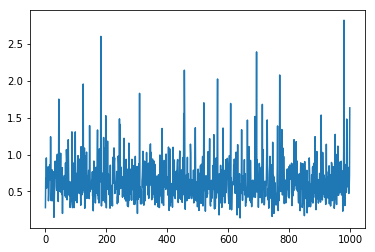

In [22]:
# User Defined Variables
Pid_red = 0.032
T_red = 2

# Define Simulation Properties
Nh_max = 1000
seed = 1731
tailcor = False
N_moves = 100
N_equil = 500
N_prod = 1000
pi_move = 0.5
s_box = 10 #[A]
delta = 1

# Define Useful Constants
s_hh = 2.958 # sigma [A]
e_hh = 36.7 # eps over kb[K]
s_me = 3.73 # [A]
e_me = 147.5 #[K]
s_hc = 3.216 # sigma [A]
e_hc = 41.924 # eps over kb[K]
kb = 1.3806*10**(7) #[Pa*A^3/K]
c_bond = 2.24 #[A]
    
# Calculated Properties
Pid = e_hh*kb*Pid_red/s_hh**3 # [Pa]
T = e_hh*T_red # [K]
Vol = s_box**3 #[A^3]
beta = 1/T #[K^-1]
ZZ = beta*Pid
Nh = floor( ZZ*Vol/kb )
print( Nh )
rc = s_box
if ( tailcor):
    rc = min([2.5*s_hh,0.5*s_box]) #[A]
    
# Run Simulation
rhov, Env, Pv, Nv = mc_run()

rho_red = s_hh**3*rhov.mean()
P_red = s_hh**3/e_hh/kb*Pv.mean()*10**(6)
print("rho*: ", rho_red, " P*: ", P_red)

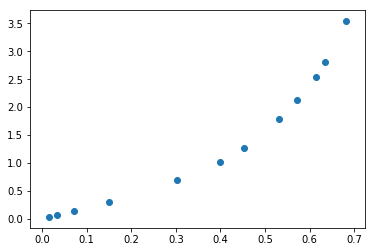

In [23]:
P_out = [ 0.03277,0.0668,0.141,0.301,0.693,1.01, 1.27, 1.79, 2.13, 2.53, 2.80, 3.54 ]
rho_out = [0.01645, 0.0334,0.0708,0.151,0.302 ,0.4, 0.452, 0.532, 0.572, 0.614, 0.634, 0.681 ]
plt.scatter( rho_out, P_out)

In [506]:
remove_test(2,2,Nv.mean())

x:  5.42920023041499  y:  1.6586121579540647  z:  9.963191465633331  o:  6
Umove:  162.28105234653563  Vmove:  -491.93954972866675
Pcorr:  0.62579738252
pa_remove:  0.0624064744071


(0.062406474407067918, 162.28105234653563)

In [389]:
Nden = 10000
ppv = np.zeros( Nden); uuv = np.zeros( Nden )
for i in range( Nden):
    pp, uu = add_test()
    ppv[i] = pp
    uuv[i] = uu

x:  9.127563598940737  y:  5.51069637216206  z:  6.884004075494559
Umove:  80309704.86482628  Vmove:  964373957.1515884
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.36384164178026  y:  2.603708119135847  z:  7.041817489061641
Umove:  3605.412506576946  Vmove:  53615.56968514599
Pcorr:  1.4528588069823754
pa_add:  5.59088837153e-21
x:  4.0209941116845505  y:  7.321243791240351  z:  2.484670847512792
Umove:  1581.666090378631  Vmove:  26343.53027726903
Pcorr:  1.4528588069823754
pa_add:  1.60855720354e-09
x:  7.179974875462442  y:  0.3040264474002574  z:  1.1075495851216732
Umove:  66702.93974709268  Vmove:  830839.8623526703
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.418742607006493  y:  3.9479366451205933  z:  5.729204833308922
Umove:  113359.79759370643  Vmove:  1394030.0713253904
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.780520687752004  y:  2.3822232913957784  z:  3.820990339582533
Umove:  1833.7816954266518  Vmove:  30167.17943125663
Pcorr:  1.4528588069823754
pa_add:  6.01028728

Umove:  2487321.6876999047  Vmove:  29975707.272213437
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.563389487762308  y:  4.618837502012636  z:  6.5631399927945235
Umove:  88877316.424941  Vmove:  1067215412.4334496
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.4319615058314441  y:  7.46483772685937  z:  7.719325309974807
Umove:  127284.2315807574  Vmove:  1562631.7827438903
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.935265270823768  y:  1.4752312238056375  z:  6.402023335110383
Umove:  61804.086603795244  Vmove:  767043.7849174882
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.7619522964385133  y:  5.357846141765696  z:  7.9397846497047
Umove:  393204.9096844098  Vmove:  4770885.522871088
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.032593905588354  y:  2.4166712496230955  z:  5.997117329365902
Umove:  38699.245471927614  Vmove:  483993.97829571227
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.9001969536275265  y:  1.3657414467916296  z:  8.639902607462853
Umove:  325370.83877113246  Vmove:  3

x:  8.180175569934425  y:  7.1164207391689684  z:  7.081342731791204
Umove:  23734.84582242947  Vmove:  306097.9355360822
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.98126818227462  y:  8.486890113005023  z:  9.050815696740258
Umove:  2160511.2541978187  Vmove:  26042891.133902248
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.4738369256824644  y:  0.491479889207036  z:  0.6243978134397843
Umove:  89963.74732901281  Vmove:  1108952.4404472862
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.247555597648433  y:  6.594429206011252  z:  6.804673425003276
Umove:  1366003.3787236644  Vmove:  16482600.078395596
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.247074634183396  y:  2.9627783849393365  z:  2.731598465253274
Umove:  3639738378136.569  Vmove:  43676999231380.34
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.2207215849843935  y:  0.595000176757059  z:  8.49751807509672
Umove:  16940.054696212046  Vmove:  219593.64318923536
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.752585530213367  y:  1.4934027

Umove:  537829996.835697  Vmove:  6455652545.60184
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.724669389163928  y:  3.6617988845189076  z:  1.85278557667108
Umove:  7845879.432607763  Vmove:  94361146.5024887
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.689301306864282  y:  8.84975634673884  z:  6.421803116670711
Umove:  89515313.86205682  Vmove:  1074877277.307155
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.421590812905126  y:  7.831743794405788  z:  2.5164278042060175
Umove:  174635.70587768548  Vmove:  2138224.2128593526
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.5484963262041531  y:  6.4045505983434  z:  8.642978396680611
Umove:  118163.31135074877  Vmove:  1450510.9866750003
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.41578099316673334  y:  6.205133510622442  z:  3.9483959032528415
Umove:  607355.0298825004  Vmove:  7350660.333889709
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.877061855616612  y:  2.3024796891118937  z:  7.900624731266434
Umove:  11829.696925048322  Vmove:  158643

Pcorr:  1.4528588069823754
pa_add:  0
x:  4.725640543229716  y:  5.223211566202874  z:  9.649069716149159
Umove:  81566.37445855293  Vmove:  1010978.2134134462
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.8476638402314816  y:  3.2041649738321176  z:  4.829941776888591
Umove:  18908.33435322397  Vmove:  241955.69291142738
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.7741277875313013  y:  0.9874686424647172  z:  5.845774553456145
Umove:  10374776.01199425  Vmove:  124735769.2323936
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.1684573594396204  y:  1.5099801920680156  z:  5.254519596778579
Umove:  5873.6632578743  Vmove:  81885.56058834915
Pcorr:  1.4528588069823754
pa_add:  8.01827150613e-34
x:  2.89375287898297  y:  6.416998962446042  z:  1.1259029219111338
Umove:  1694979.58127227  Vmove:  20436913.675348908
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.650508419760037  y:  8.188479366845876  z:  5.502885278430714
Umove:  137714.69025385092  Vmove:  1682943.3301685804
Pcorr:  1.452858806982

Umove:  12659347.109177548  Vmove:  152174311.38403678
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.337173909008958  y:  7.3558820240556875  z:  5.81606975374525
Umove:  50216.20417717284  Vmove:  627700.7372533455
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.275035447846838  y:  9.495916047778241  z:  8.93931803854944
Umove:  7532703.147375026  Vmove:  90608837.61203422
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.49625614625811  y:  0.8011726074573666  z:  2.757145203380593
Umove:  3284.385371651484  Vmove:  49201.70521103427
Pcorr:  1.4528588069823754
pa_add:  3.67465292897e-19
x:  8.3865902938325  y:  3.5071610367023975  z:  5.508454897734266
Umove:  3007.347332322064  Vmove:  45909.75762559632
Pcorr:  1.4528588069823754
pa_add:  1.36105171827e-17
x:  1.0584389026778818  y:  4.12794509196034  z:  8.40386016133871
Umove:  167021.4382575827  Vmove:  2043992.0589191248
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.0415206064025404  y:  8.416216301509042  z:  1.2097459672546673
Umove:  3071

x:  9.258101672706273  y:  4.130825189962821  z:  8.579222149086744
Umove:  464255.70002323284  Vmove:  5632007.683323715
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.647882112243766  y:  8.281000935826388  z:  5.9671752500214446
Umove:  5837.535544427111  Vmove:  81746.85665760534
Pcorr:  1.4528588069823754
pa_add:  1.28423605737e-33
x:  9.315939189989395  y:  4.045181457044298  z:  2.059206466306841
Umove:  168.06692075581745  Vmove:  7678.013898798446
Pcorr:  1.4528588069823754
pa_add:  0.162400249566
x:  5.777201386540653  y:  7.629714870272291  z:  8.058313286971359
Umove:  58895565.24320419  Vmove:  707310342.3277154
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.65564875208661  y:  8.215461055195197  z:  7.731589721974536
Umove:  474.1416286389888  Vmove:  11239.939970891714
Pcorr:  1.4528588069823754
pa_add:  0.00300272492586
x:  0.7564183424062154  y:  0.4729599471682977  z:  3.115549272148658
Umove:  63382120.27281141  Vmove:  761167871.8551124
Pcorr:  1.4528588069823754
pa_add: 

x:  5.091922359908853  y:  1.3119540735664337  z:  0.8705843310023365
Umove:  2713704985.6257706  Vmove:  32568253392.53679
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.603024562887752  y:  2.048372651751138  z:  8.289181863975651
Umove:  1744395.3809470108  Vmove:  21037324.001147967
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.122466628454556  y:  5.7096770371687615  z:  4.329227090791782
Umove:  2761337009.2075744  Vmove:  33139868715.445724
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.6726604062312354  y:  5.749572342578251  z:  9.599413628405022
Umove:  148773502961.3972  Vmove:  1785310078229.9827
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.4997618858918549  y:  3.8216494353215182  z:  5.594427501750364
Umove:  1219.7762684487668  Vmove:  21512.552686737297
Pcorr:  1.4528588069823754
pa_add:  1.80113686324e-07
x:  5.9940273627719005  y:  2.745271843745869  z:  6.913600179464269
Umove:  268843.68340869097  Vmove:  3270691.7433548607
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.7485535

Umove:  9852.476538402298  Vmove:  129139.14962854913
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.4024433104736245  y:  5.549808135062725  z:  2.6533581026143294
Umove:  2572.2302424868735  Vmove:  40694.80809896304
Pcorr:  1.4528588069823754
pa_add:  3.95927658892e-15
x:  8.818243469221208  y:  5.2074600979510075  z:  7.263878474648986
Umove:  212213125.23010653  Vmove:  2547621730.6485558
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.749088679689475  y:  8.416111958281295  z:  1.7430059267890707
Umove:  4225743.360899705  Vmove:  50862284.02991526
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.308428607882919  y:  3.7332551204294875  z:  3.3907535457298743
Umove:  8463.301726046946  Vmove:  114394.32991030533
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.1536215330427959  y:  1.4668398391987503  z:  4.268097757304136
Umove:  10686.215628487993  Vmove:  141225.24625960534
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.810059758828082  y:  6.477938624692183  z:  7.150508178110949
Umove:  58902.1

Umove:  6655.372905839826  Vmove:  93723.74188286209
Pcorr:  1.4528588069823754
pa_add:  3.00501228912e-38
x:  4.4170491397031855  y:  5.536628444476187  z:  4.439651511098358
Umove:  2608564.4523124476  Vmove:  31424700.41296287
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.807190369070199  y:  1.2983735961565968  z:  7.772371114995336
Umove:  312359.00147308246  Vmove:  3799126.448591897
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.104275884343612  y:  1.1674696480358926  z:  9.365040803020493
Umove:  19688861.95566182  Vmove:  236592953.54385218
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.038743599389174  y:  2.051249946085635  z:  2.20514473292875
Umove:  13137.86769218898  Vmove:  173729.8516101889
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.996419713520916  y:  0.8733736634757217  z:  3.811024787617333
Umove:  751138.6776648804  Vmove:  9082765.709173895
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.588176065684387  y:  3.0524044196698807  z:  5.1687601319830145
Umove:  5814.364690302

x:  2.7373015325542225  y:  5.97383180069685  z:  1.1886490928962024
Umove:  4307033.393996461  Vmove:  51837765.88505182
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.7042671590159866  y:  2.9552537457329087  z:  5.153097408614247
Umove:  520.2082887431109  Vmove:  12300.088598755709
Pcorr:  1.4528588069823754
pa_add:  0.00164692817305
x:  9.74331992695973  y:  4.705310421171176  z:  9.933567180621509
Umove:  49792.71851152119  Vmove:  619941.3673055201
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.38948432668032495  y:  7.239280346606111  z:  2.2267800429639575
Umove:  941103.6682261693  Vmove:  11367807.973277073
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.998571152502147  y:  8.411835729126546  z:  0.8131150222380257
Umove:  32216551.77061366  Vmove:  387014660.6417149
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.4435396990953566  y:  3.4513233378913477  z:  4.4444190850011625
Umove:  12257.683661225987  Vmove:  160785.04077679687
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.725875587940

x:  9.232587416851723  y:  6.863798909394669  z:  9.661583264959228
Umove:  144626401.01899335  Vmove:  1736397024.6083224
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.321783775643004  y:  7.357852069581172  z:  5.561814550097898
Umove:  11099669.75884521  Vmove:  133444752.1526001
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.98820505408108  y:  9.22230020729824  z:  9.627106572499137
Umove:  1068402364.1917335  Vmove:  12823207890.240252
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.9722480608826831  y:  1.5746659838847432  z:  5.0602742252890165
Umove:  19965.03402523463  Vmove:  254223.67676802468
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.7072389975935598  y:  4.784885625352055  z:  7.051638416639107
Umove:  31449.1531784883  Vmove:  395929.7535270022
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.20835187893251894  y:  9.076061247931763  z:  7.01880919884726
Umove:  1326392.5949653473  Vmove:  16012234.111476537
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.8523970467474917  y:  0.7197024

Umove:  6488412.064007979  Vmove:  78053942.89979102
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.133010595053442  y:  4.416381948070062  z:  7.400228558865656
Umove:  272668.5969452103  Vmove:  3327442.7471891134
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.495267400713531  y:  1.3564648679453617  z:  9.14627085522312
Umove:  162310.86698327263  Vmove:  1981770.1499270273
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.6330463350354463  y:  8.722144577498502  z:  6.1183235297172045
Umove:  113167.52157281074  Vmove:  1393072.2502234208
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.107671017392528  y:  0.6732003858573532  z:  3.5181383717448442
Umove:  28767.0807515719  Vmove:  365363.870976595
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.3868210797433367  y:  9.535818767654172  z:  4.260556693590647
Umove:  13222.530516938152  Vmove:  174626.41469597077
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.8617851081427927  y:  0.14039185132838528  z:  0.750028833990497
Umove:  266232.3719742916  Vmove:

Umove:  29220.486346206657  Vmove:  369626.48238037975
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.2447306694426428  y:  9.587297228673771  z:  7.826854210218825
Umove:  194585.36439316667  Vmove:  2383115.0024825367
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.5693286118569625  y:  7.066444104564696  z:  1.4082532716431384
Umove:  11846.8446327066  Vmove:  153259.3906068289
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.7986737448957273  y:  4.766691417137363  z:  3.6610708529621117
Umove:  4466.578784750055  Vmove:  63490.88799637735
Pcorr:  1.4528588069823754
pa_add:  7.43606380958e-26
x:  8.497819371940215  y:  6.757317703468751  z:  8.640559038079262
Umove:  380529.98547431355  Vmove:  4626665.375348254
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.8860047737419325  y:  7.844280442234767  z:  4.086726492930626
Umove:  5170663.466138603  Vmove:  62215557.71080635
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.698451803427412  y:  8.335148982776309  z:  8.627625143043634
Umove:  6017226.0127

x:  0.7248577204566997  y:  5.904447967166489  z:  5.3394404681210315
Umove:  66584.79218646364  Vmove:  824049.7115925392
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.6281737239301215  y:  5.614592224976701  z:  4.53201724880927
Umove:  817.1724080063785  Vmove:  15584.902999010552
Pcorr:  1.4528588069823754
pa_add:  3.42917725899e-05
x:  5.007114663912042  y:  0.3921200389270596  z:  5.847130902088754
Umove:  1175313.6526693034  Vmove:  14189793.079321919
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.52332227502965  y:  4.71041874868858  z:  1.2705838122290358
Umove:  576.1779546087569  Vmove:  12749.868717282649
Pcorr:  1.4528588069823754
pa_add:  0.000793890282805
x:  5.110831278044485  y:  5.115104469803975  z:  9.076675813816662
Umove:  5888.625511011234  Vmove:  83202.41942080046
Pcorr:  1.4528588069823754
pa_add:  6.59721682834e-34
x:  3.120004560656472  y:  0.961304835971647  z:  1.0503719867101036
Umove:  42221.21686869023  Vmove:  527440.5023154697
Pcorr:  1.4528588069823754
pa

x:  0.6739494037668137  y:  0.5320091393872728  z:  1.212907645335497
Umove:  31743799.607611112  Vmove:  381341409.692812
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.052925358204012  y:  7.070497805461708  z:  5.674888860059582
Umove:  210233.73820923973  Vmove:  2570158.2059897054
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.228109600317328  y:  9.849429665574368  z:  7.195951328232267
Umove:  13226.987728625323  Vmove:  177147.0012241905
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.3248655850285616  y:  6.229469464871951  z:  1.7946462056836698
Umove:  14517.735543723915  Vmove:  185557.392696138
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.41142944183234  y:  5.863651277065732  z:  4.4996815485787724
Umove:  50851.54208489913  Vmove:  636904.1798028499
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.5464959279484258  y:  9.970692678162603  z:  8.965474649801642
Umove:  13220737.45616929  Vmove:  158921608.38165784
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.178382904310393  y:  7.18086940

Umove:  9412.279135911687  Vmove:  128127.239104773
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.489920475529365  y:  4.923540893910735  z:  5.981310731100271
Umove:  46063.78781319918  Vmove:  577276.7737089619
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.4475298785034223  y:  3.161114337131826  z:  7.913239924108211
Umove:  14075.17613964297  Vmove:  180806.36707843246
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.473329434369171  y:  0.9397195057466123  z:  7.882071477005994
Umove:  9074.627837685393  Vmove:  121488.4612302955
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.667380589410994  y:  6.315372310299155  z:  0.6132515953224149
Umove:  69349.2204826974  Vmove:  855978.5917493437
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.214254172286989  y:  7.518196031717061  z:  9.206241001355245
Umove:  89809250.47057642  Vmove:  1078406950.4266655
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.592123463879595  y:  5.768925163503363  z:  6.165880685869418
Umove:  441119.1998238008  Vmove:  5344237.

pa_add:  0
x:  2.8373563442450833  y:  0.07880140568839233  z:  5.619406597744344
Umove:  65321.689947831175  Vmove:  812294.4918003364
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.1574079113459446  y:  4.626396572054203  z:  6.3437649799011275
Umove:  4725.801074189568  Vmove:  67148.15854880525
Pcorr:  1.4528588069823754
pa_add:  2.53257324253e-27
x:  3.0334274994857235  y:  5.89379311681898  z:  1.1536528393498002
Umove:  9473839.778056154  Vmove:  113912734.46073245
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.279791465674593  y:  6.281366751433958  z:  7.405786417444233
Umove:  199254.47355256803  Vmove:  2435584.9541498595
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.219955782008917  y:  7.562309041053062  z:  4.004526968342707
Umove:  144117.9863535913  Vmove:  1763333.8264377909
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.2684351444377542  y:  5.701266033633987  z:  7.270859927384325
Umove:  196596233.96136823  Vmove:  2360178921.6350656
Pcorr:  1.4528588069823754
pa_add:  0
x:  7

Umove:  1373.374897227367  Vmove:  24402.5609805528
Pcorr:  1.4528588069823754
pa_add:  2.43126929599e-08
x:  3.128761789512361  y:  0.7389673854985923  z:  8.562185039884861
Umove:  14562.448704260087  Vmove:  190199.96740889538
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.354749386024153  y:  9.436274645331224  z:  3.066724690833621
Umove:  16129.856277522178  Vmove:  212852.74980396283
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.268649289343752  y:  3.37208609721251  z:  6.490393990965979
Umove:  3160.782321717724  Vmove:  47923.33246451572
Pcorr:  1.4528588069823754
pa_add:  1.8411431043e-18
x:  4.076985162729003  y:  1.4598763884888633  z:  0.6366217494273674
Umove:  2373921413.9011292  Vmove:  28490602262.070774
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.1641426414136757  y:  2.2961913140742265  z:  3.333197299966053
Umove:  2930640.2643581047  Vmove:  35296278.416001886
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.5433723530397336  y:  2.5129683351561938  z:  2.5672289732187172
U

x:  8.15548935683009  y:  6.190755847504543  z:  4.523736703668745
Umove:  383759.8744693291  Vmove:  4657333.8710447615
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.0311860273145586  y:  1.7328121849255507  z:  4.492690880285876
Umove:  10552.612690945001  Vmove:  138881.1871532333
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.653128493169792  y:  8.095960558334978  z:  8.329587516253289
Umove:  500923.1499521922  Vmove:  6072426.490832948
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.301650235211259  y:  6.008872006990159  z:  9.660391626626593
Umove:  68060.84339639766  Vmove:  840908.6321300082
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.22150594300146  y:  8.509193470547242  z:  3.314391127685653
Umove:  1848598.4140809732  Vmove:  22308513.43259991
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.0174108296247475  y:  1.3536881251338084  z:  6.394398311339437
Umove:  1435887.9935859845  Vmove:  17323603.03545714
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.221723966240375  y:  9.24565063673

x:  4.097524672752899  y:  3.8133992078709547  z:  8.83848965592458
Umove:  1741.897304587142  Vmove:  29522.770771122418
Pcorr:  1.4528588069823754
pa_add:  1.99144130974e-10
x:  4.884524928120651  y:  4.954107652682379  z:  4.97655957291358
Umove:  256508668.07390678  Vmove:  3079276596.114707
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.260592167121381  y:  5.218618278862897  z:  7.076862837326639
Umove:  45230772.02342228  Vmove:  543262392.161543
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.022306434309776  y:  1.9119290418528712  z:  5.09618405846846
Umove:  271933.22085969953  Vmove:  3319764.8679578756
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.9311356170775242  y:  4.257833314386442  z:  5.540587781160994
Umove:  4702.444122180408  Vmove:  65754.81545689423
Pcorr:  1.4528588069823754
pa_add:  3.43411541709e-27
x:  4.681363865257109  y:  5.174417339916543  z:  2.9194972125527707
Umove:  19731.25769598631  Vmove:  253920.67403865466
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.335

Pcorr:  1.4528588069823754
pa_add:  0
x:  1.596175373333918  y:  1.7221053134732545  z:  8.97213497197036
Umove:  35829.45830560003  Vmove:  451074.199883541
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.9666282956139733  y:  5.114270613737513  z:  1.7344976859518735
Umove:  60226.319291092936  Vmove:  748967.8078309265
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.462360425207483  y:  6.915605127294228  z:  1.0180573045899866
Umove:  4800.229689678516  Vmove:  68545.49494222875
Pcorr:  1.4528588069823754
pa_add:  9.59684932839e-28
x:  6.147355961217874  y:  4.093033376692383  z:  6.048099381218556
Umove:  41713.13554659104  Vmove:  523108.06028149487
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.801305836856901  y:  4.245271462374687  z:  4.630996032905047
Umove:  31754.161254116178  Vmove:  399516.1581847742
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.358466881564784  y:  6.400407447090957  z:  0.5219277129574806
Umove:  13572.460971457893  Vmove:  176208.09751458612
Pcorr:  1.452858806982

Umove:  58981.174711011045  Vmove:  735223.8378953525
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.903653844938577  y:  2.7625243468721026  z:  3.640306036235972
Umove:  17430.202650285533  Vmove:  223988.63402921124
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.992657563390674  y:  2.5290241787929144  z:  3.384475081445122
Umove:  8534978.64920139  Vmove:  102634906.48977761
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.3314786529760936  y:  8.4844067270862  z:  8.644532784966572
Umove:  974338.8621792818  Vmove:  11769870.242275089
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.668309065934378  y:  8.096242099681346  z:  9.702144313888951
Umove:  7112.6010445999555  Vmove:  99962.60493629186
Pcorr:  1.4528588069823754
pa_add:  7.74295577412e-41
x:  0.6834913530278808  y:  9.039498344353357  z:  4.91971347035225
Umove:  88431.97317184755  Vmove:  1089125.935529054
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.256288639743321  y:  7.468216368338352  z:  7.731330456471034
Umove:  15170630117.7873

Umove:  1423.860557034775  Vmove:  24027.171622233982
Pcorr:  1.4528588069823754
pa_add:  1.25884047898e-08
x:  3.256513803529295  y:  2.2862665702442833  z:  2.216899820132523
Umove:  117741.78525201995  Vmove:  1442227.0576659497
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.6501386747842046  y:  2.5276277231692656  z:  7.030713882939069
Umove:  4632.387230310875  Vmove:  64539.580570119564
Pcorr:  1.4528588069823754
pa_add:  8.56040748781e-27
x:  1.9693067070186332  y:  7.0221694314469545  z:  5.521700861977904
Umove:  3695.45465557596  Vmove:  52605.75937351823
Pcorr:  1.4528588069823754
pa_add:  1.72838214932e-21
x:  2.407194887813916  y:  7.318425277915139  z:  1.0970993530560025
Umove:  10085.63929264337  Vmove:  132762.8836815114
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.915183834403283  y:  3.470500296890667  z:  1.9295782530390138
Umove:  9169.508990440174  Vmove:  123804.58839350683
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.276175204965133  y:  3.495765434209969  z:  9.133

Umove:  273816.1248172691  Vmove:  3343915.3454418317
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.276995972458378  y:  8.990277681361615  z:  9.575743321471522
Umove:  10464.106595947254  Vmove:  142578.450263151
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.01161785036469909  y:  2.431181794354739  z:  1.037168600927073
Umove:  125710.0178298651  Vmove:  1540152.1630645853
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.938186592523277  y:  2.6276864954934096  z:  8.151885972991593
Umove:  39834.90404357645  Vmove:  501080.1341698321
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.052697281285951  y:  6.2967996451619745  z:  1.9506256058506577
Umove:  26608.85583235335  Vmove:  335557.6060757652
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.478541027027546  y:  4.510728258690284  z:  8.503020572012156
Umove:  292685.43907390867  Vmove:  3562608.9755778136
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.937460903857224  y:  6.6144071020449715  z:  7.468046974708584
Umove:  8643713907.313536  Vmove:  1

x:  3.713032893094166  y:  9.573621909939815  z:  8.388750826288152
Umove:  26447.600318720655  Vmove:  334132.05255186564
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.726762499533895  y:  5.531461620771886  z:  3.1768381394077982
Umove:  261531.97627149022  Vmove:  3183017.8802588577
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.384158960930514  y:  1.2238888227912903  z:  9.19429547996337
Umove:  40838.485556137806  Vmove:  516694.156790833
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.5140923963880715  y:  3.4429185031657483  z:  6.104961158067473
Umove:  8543.330100626998  Vmove:  118235.41275775655
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.184752672193591  y:  1.5409747679745278  z:  9.241203933412907
Umove:  1628684.2297357293  Vmove:  19645137.42529722
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.4519150542292938  y:  5.263256084878556  z:  2.987316939420835
Umove:  65494.190883036616  Vmove:  809348.4954814316
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.019610938681836  y:  0.10561

pa_add:  4.51390702372e-24
x:  5.301030698241469  y:  2.898998943372444  z:  4.7699768297468506
Umove:  885296.3148819533  Vmove:  10697383.135279248
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.752124615955887  y:  9.094349537486453  z:  6.374158679251507
Umove:  2786526.483449514  Vmove:  33581817.36079272
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.440090244395897  y:  0.6358800166619083  z:  9.216750902214937
Umove:  600875.8379191353  Vmove:  7272590.034532568
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.046991965704982  y:  2.991559873285955  z:  4.883601557919892
Umove:  385468.00547319284  Vmove:  4676703.233432212
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.4904425528261058  y:  1.2135546674991549  z:  5.11633328451028
Umove:  22843.34234747636  Vmove:  291840.5837326178
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.170265875936118  y:  4.438935842167852  z:  7.162624682635305
Umove:  539226.527140251  Vmove:  6530084.747199247
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.081908124

pa_add:  0
x:  5.553226010560319  y:  6.094681994594399  z:  5.929769245928364
Umove:  935118.9491373617  Vmove:  11301033.778890278
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.438612225351643  y:  8.50982791364005  z:  2.062812221430251
Umove:  185953.033723746  Vmove:  2275128.2958443766
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.9423805098444946  y:  1.655820381759936  z:  4.281512036389761
Umove:  6097.482475090923  Vmove:  84379.03484449736
Pcorr:  1.4528588069823754
pa_add:  4.33272042796e-35
x:  7.844156621606243  y:  6.566168135253241  z:  3.3150117443435634
Umove:  187884.49934526454  Vmove:  2294605.638328576
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.55719328998175  y:  7.40757912912998  z:  2.053125097371964
Umove:  109788.7915522632  Vmove:  1348044.666777245
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.25918210952768583  y:  3.1265101477703094  z:  6.736518772028203
Umove:  432.6930648759931  Vmove:  11643.824602317205
Pcorr:  1.4528588069823754
pa_add:  0.00515475025702

x:  4.397156481948703  y:  6.3230510420049235  z:  8.154188738824296
Umove:  9814.207522188952  Vmove:  131510.34843964712
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.97598871875552  y:  3.096297553218043  z:  0.6551827432384638
Umove:  7098224.071652688  Vmove:  85376018.11281174
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.575151164923577  y:  8.997388216462936  z:  7.882487635010506
Umove:  6418.517655975825  Vmove:  86843.93759876186
Pcorr:  1.4528588069823754
pa_add:  6.59142938022e-37
x:  6.535390003802708  y:  2.8794430028587845  z:  1.8891065952625274
Umove:  13090489.18803009  Vmove:  157358193.70520407
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.881029386307468  y:  5.146364579332914  z:  9.425111574779395
Umove:  45449.00880745465  Vmove:  566357.3864247367
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.385192156501056  y:  3.2808433409987425  z:  9.07654986374168
Umove:  486565.81296691665  Vmove:  5897684.08114429
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.213974817265371  y:

Umove:  4097150.0594957266  Vmove:  49322205.25811942
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.002400648951934592  y:  8.922475934754434  z:  9.16983463288145
Umove:  302422.54005962657  Vmove:  3686239.0249735545
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.61661080631453  y:  6.220123808587901  z:  7.069077676918313
Umove:  37967370.61998636  Vmove:  456061215.1530715
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.4771064703122665  y:  5.752716142268056  z:  5.485195231665463
Umove:  8898678.361644272  Vmove:  107006885.56228468
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.003108570658593  y:  0.7237004304543349  z:  4.549491053055469
Umove:  192745.34608556586  Vmove:  2357090.885049862
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.2947430651013034  y:  5.238673480523175  z:  5.86784390868435
Umove:  337321.6370017146  Vmove:  4092757.6730945124
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.243933387665537  y:  8.34222642765625  z:  0.22912412078328948
Umove:  379265.22625789704  Vmove:  

x:  9.79656275433023  y:  6.160276498858167  z:  6.7700709639397445
Umove:  3183770.399912128  Vmove:  38348932.31406051
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.124719384132703  y:  3.3170512781183534  z:  7.576356234906064
Umove:  46685.137262727156  Vmove:  585393.1407761049
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.1990793173465373  y:  7.273432688739678  z:  5.4995685541748305
Umove:  2355.802417192512  Vmove:  36106.80700210681
Pcorr:  1.4528588069823754
pa_add:  6.65401894487e-14
x:  0.12084079569390394  y:  0.6791958107678475  z:  6.535106659289531
Umove:  1429388.5278559374  Vmove:  17247014.258719083
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.761060288566831  y:  5.530878890758094  z:  2.56300163563429
Umove:  71026.81156760616  Vmove:  881500.4749517349
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.042775485286646875  y:  6.15994631573361  z:  4.451594987163801
Umove:  16316410.237173496  Vmove:  196096406.65923238
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.967713461636

x:  9.430409251807239  y:  0.3926782425000297  z:  5.6516112731782195
Umove:  1069984.4026660232  Vmove:  12922917.651079994
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.756276942908352  y:  7.489831546086184  z:  8.236005990264205
Umove:  52290.98478536684  Vmove:  647796.295726401
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.191902195062953  y:  5.464947339108973  z:  2.7271340367879016
Umove:  3532.6978934856475  Vmove:  51438.21553928162
Pcorr:  1.4528588069823754
pa_add:  1.44280969157e-20
x:  0.5566509227832839  y:  1.7902741277753698  z:  0.9773539987796975
Umove:  39038.0854015846  Vmove:  493073.3383349526
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.669309013423412  y:  9.425169574512433  z:  5.811020757047801
Umove:  405036.8595188435  Vmove:  4917357.792969992
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.470089415774156  y:  3.193165520244322  z:  9.264167040454646
Umove:  84540.27997728364  Vmove:  1041738.0624442749
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.54368478007431  

x:  8.25272590060859  y:  4.665000496760609  z:  6.930153719366538
Umove:  123205.88067966804  Vmove:  1514652.4187872312
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.1784105857542437  y:  7.057565251859213  z:  6.759456436036694
Umove:  304669.4863366403  Vmove:  3700767.178164098
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.390511222945248  y:  1.0512010638222036  z:  3.3954672769823526
Umove:  248302.09494826675  Vmove:  3024748.5418526838
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.219178445743167  y:  4.582141443240168  z:  0.2509869858117908
Umove:  14245227.183396557  Vmove:  171221721.61856103
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.708823852266091  y:  9.404238543371154  z:  3.8948230984141077
Umove:  1224556.6800491004  Vmove:  14784756.215394815
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.945235302486608  y:  4.092847713382285  z:  6.186432293463396
Umove:  29140.059139555164  Vmove:  370303.2416155709
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.1325524909368414  y:  8.023

x:  4.470084048261949  y:  9.940406858598724  z:  4.858992771493323
Umove:  193619.14529996528  Vmove:  2371871.4720824156
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.626053982228097  y:  3.5166393843131463  z:  8.208714440850112
Umove:  2895.126052511461  Vmove:  43302.077880476245
Pcorr:  1.4528588069823754
pa_add:  5.87894549222e-17
x:  7.90066654253609  y:  9.749107331111786  z:  5.723873791172577
Umove:  835812.7181062648  Vmove:  10104544.463358665
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.7368433590254235  y:  5.750256881376239  z:  3.3222535364748538
Umove:  806.9631358688173  Vmove:  15442.11969352975
Pcorr:  1.4528588069823754
pa_add:  3.91739508193e-05
x:  5.042558592248297  y:  9.819193031759454  z:  4.699826843820104
Umove:  103954.88265064075  Vmove:  1287675.0748414898
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.4785144659707663  y:  5.397377970242653  z:  1.337884639343786
Umove:  233.35619802688294  Vmove:  8852.842683936748
Pcorr:  1.4528588069823754
pa_add:  0.0693

Umove:  116940.60455735943  Vmove:  1439541.7568927805
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.551588017370907  y:  2.244653401345995  z:  3.0583506059473873
Umove:  1064.1295139920421  Vmove:  20786.10945075946
Pcorr:  1.4528588069823754
pa_add:  1.37043159101e-06
x:  3.514420092166727  y:  2.8141760050511087  z:  1.0680491356209998
Umove:  14642.382579765106  Vmove:  190602.99912191895
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.041254710770653  y:  0.5803063497253225  z:  2.879903801981035
Umove:  6626.617807885669  Vmove:  93750.36895475934
Pcorr:  1.4528588069823754
pa_add:  4.37184514981e-38
x:  7.799009349631239  y:  4.151292512880551  z:  8.294874990101272
Umove:  2519354.506924553  Vmove:  30355307.323268086
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.21890097621016347  y:  0.56086841131333  z:  2.029813112824488
Umove:  7645409064.877727  Vmove:  91751268947.26363
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.290941980401884  y:  3.589601106884154  z:  6.726407838694718
Umo

Pcorr:  1.4528588069823754
pa_add:  0
x:  9.448904311628883  y:  2.243760014398044  z:  9.644523373558942
Umove:  355311.51259345724  Vmove:  4328147.170307847
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.423975383519723  y:  6.296616711221981  z:  0.8487648305986151
Umove:  43022.73489068125  Vmove:  540482.2341920335
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.2483400601645678  y:  0.05984904665554125  z:  1.5843800048244128
Umove:  681977292.8729327  Vmove:  8185631424.503841
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.7821961614133133  y:  8.111081840326335  z:  1.137269882337597
Umove:  7956.016858974836  Vmove:  111090.95060766877
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.4708704385722147  y:  2.484221495507115  z:  7.6648630159556
Umove:  884.087441668212  Vmove:  16882.559402260737
Pcorr:  1.4528588069823754
pa_add:  1.43317877203e-05
x:  7.606372729637764  y:  4.439119470938295  z:  3.6542377691004346
Umove:  9962.465091631226  Vmove:  132271.63325310202
Pcorr:  1.45285880698

pa_add:  0
x:  4.20378144225411  y:  8.828282925515865  z:  6.086078065650061
Umove:  4470.354541882608  Vmove:  63650.33350243559
Pcorr:  1.4528588069823754
pa_add:  7.07886828531e-26
x:  9.5198595046042  y:  8.291696264754972  z:  0.11777331592275675
Umove:  531604883.72460145  Vmove:  6380941796.312295
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.9951181068384574  y:  1.20191446878675  z:  4.923217828310409
Umove:  23042.996385148774  Vmove:  292312.4821468282
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.817803990726656  y:  1.2122241820148671  z:  1.6086335008136843
Umove:  417477.70713206934  Vmove:  5062689.547599729
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.862209019473539  y:  1.0561539294639999  z:  1.8750775152492427
Umove:  138268.50731404973  Vmove:  1694067.7024796149
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.4820741304980247  y:  9.714393184580514  z:  1.8570998519764503
Umove:  87140949142.60011  Vmove:  1045712853850.3901
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.49

Umove:  18382.89324637127  Vmove:  234439.7965207258
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.780427872291167  y:  4.015323949201994  z:  9.475979117404446
Umove:  16545.60159216752  Vmove:  214926.12463233655
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.04151454935457  y:  5.282730879712341  z:  8.101457269057681
Umove:  11310.408309709243  Vmove:  150467.69018491433
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.225462542858295  y:  4.96155165491082  z:  0.30854954716813765
Umove:  1487.6844460658003  Vmove:  25569.443799123557
Pcorr:  1.4528588069823754
pa_add:  5.47751986591e-09
x:  8.398282389170257  y:  9.813069892691304  z:  8.108748439185463
Umove:  337532.26910508587  Vmove:  4103425.3892869605
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.32200040089577  y:  1.1758945581490188  z:  8.218445365325186
Umove:  165306.47403957415  Vmove:  2022166.2827394456
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.877342679170928  y:  1.7324916497148757  z:  8.11394451527301
Umove:  45371.2361865

Umove:  193041564.48438966  Vmove:  2317513877.0104423
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.4027216846877995  y:  7.982916910171632  z:  3.947096503920701
Umove:  58384567.16684843  Vmove:  701172923.4731525
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.202568086962412  y:  9.44621952844101  z:  9.557167210926508
Umove:  13982.335751985733  Vmove:  185477.6916913033
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.412822700354297  y:  9.450880765534862  z:  0.399931618736451
Umove:  5741847.385626245  Vmove:  69088034.22009513
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.212785222054343  y:  0.99703255415309  z:  8.928750636542546
Umove:  302786.95725853107  Vmove:  3685146.1397851203
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.976059177292744  y:  9.10087947370979  z:  9.18856030156823
Umove:  9491.962896099312  Vmove:  127504.86396176924
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.075259743366771  y:  4.700479363085757  z:  9.430540408944893
Umove:  4304.719366260841  Vmove:  62543.70

Umove:  7556257.311614202  Vmove:  90879512.35267681
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.48472307640101  y:  7.590971613639378  z:  4.821729056295437
Umove:  11861.33578613371  Vmove:  160119.04446478462
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.542540122370559  y:  7.254274111926038  z:  7.907003853756263
Umove:  7400855.641418805  Vmove:  89015599.75192755
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.21672600269265097  y:  1.2052442469923275  z:  0.9216825440159848
Umove:  88483.45008008377  Vmove:  1094359.293814216
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.5761485468420002  y:  0.2673983792326362  z:  7.237724917461969
Umove:  17208415.078948747  Vmove:  206810786.22294658
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.502713013825701  y:  7.982751679635589  z:  8.231634093636046
Umove:  3439.065974251991  Vmove:  50151.27528380007
Pcorr:  1.4528588069823754
pa_add:  4.89075910268e-20
x:  1.0450966053023758  y:  2.1335803003544793  z:  3.0596526621539724
Umove:  711271.0045

Pcorr:  1.4528588069823754
pa_add:  0
x:  6.754828819781413  y:  4.028496503783709  z:  6.880612617752285
Umove:  1172182.2912969275  Vmove:  14149637.59120196
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.930022121094172  y:  8.600408662425131  z:  0.622710626136066
Umove:  482826.92593481817  Vmove:  5848458.869562894
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.030201110272614073  y:  1.6335168282648505  z:  7.532664783933715
Umove:  35184.10331423889  Vmove:  445808.2213047605
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.190624480158927  y:  6.933492114250171  z:  5.937344833497852
Umove:  62181.964115170966  Vmove:  779579.5341054347
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.910659718170708  y:  7.169675496605099  z:  0.5300653544347333
Umove:  29321927.00325587  Vmove:  352271156.34577197
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.609817244635565  y:  6.697404654371638  z:  1.2496316683427777
Umove:  620835.8277484062  Vmove:  7517820.572552308
Pcorr:  1.4528588069823754
pa_add:  

Umove:  22109290.767261595  Vmove:  265658599.32647094
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.622783200066041  y:  4.73719384983726  z:  6.7908609498438866
Umove:  3492528203436063.0  Vmove:  4.191034273743303e+16
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.118061838356356  y:  5.2920374536629575  z:  1.3987485675402334
Umove:  1232.646855543002  Vmove:  21904.75585323089
Pcorr:  1.4528588069823754
pa_add:  1.52289600963e-07
x:  6.390159716383678  y:  3.5415079260929216  z:  8.251393601999196
Umove:  13352435.305232853  Vmove:  160498240.43578893
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.6325603464252172  y:  1.3804036402663933  z:  1.355407880844175
Umove:  414482.55233027675  Vmove:  5027530.5622102395
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.4863396229778725  y:  7.036958744231535  z:  5.908022114646072
Umove:  94290.381095289  Vmove:  1157221.4004919478
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.2650911204628645  y:  4.713780987154753  z:  8.711805867822447
Umove:  70915

Umove:  220631.56611334556  Vmove:  2688582.6926986133
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.525117010281654  y:  5.034238436727863  z:  6.056871165418726
Umove:  212672.9981061279  Vmove:  2602378.0924124294
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.0483030580716743  y:  6.670421345941565  z:  2.2079042908359647
Umove:  888.8660115693099  Vmove:  16112.182214198456
Pcorr:  1.4528588069823754
pa_add:  1.34661334873e-05
x:  1.3227684684286822  y:  1.0525980025449777  z:  4.264395945768728
Umove:  2713.430901013477  Vmove:  42639.610312373115
Pcorr:  1.4528588069823754
pa_add:  6.28206729849e-16
x:  1.1337712333339556  y:  2.1264602126501475  z:  5.157907813175492
Umove:  5271.5998148327935  Vmove:  72930.2397071748
Pcorr:  1.4528588069823754
pa_add:  2.05642917832e-30
x:  1.059972628500233  y:  8.310858174886173  z:  5.6069749808374505
Umove:  10180914.794046173  Vmove:  122407645.18616754
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.83629956529688  y:  8.65578058612098  z:  6.47

x:  5.69847460804038  y:  7.724572172130232  z:  9.599586224770254
Umove:  10694.428311883708  Vmove:  141464.02774914025
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.464323922576542  y:  2.091236953889044  z:  8.813773115778528
Umove:  133594.6246482525  Vmove:  1638395.933218323
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.998676085606003  y:  7.51448979090672  z:  3.0817183874387934
Umove:  82933.00772880366  Vmove:  1027781.9240345865
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.723959305348012  y:  0.7079810629453243  z:  6.467284640481257
Umove:  72726.51902049065  Vmove:  903105.7376052171
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.227518444879817  y:  9.0470351649109  z:  4.978402377511221
Umove:  4114139.211795299  Vmove:  49524240.077507086
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.6709975096813254  y:  9.729513980253037  z:  8.481253109836114
Umove:  36456.83538234398  Vmove:  456614.30560723826
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.3393065251051235  y:  8.667363615156

Umove:  2536284.275558477  Vmove:  30555874.615392383
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.3304753650562935  y:  2.493437156527485  z:  2.132207197073035
Umove:  117616.47823712742  Vmove:  1440837.032399557
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.1072471016544405  y:  9.58239427585406  z:  0.010475118536755756
Umove:  43492.92103091708  Vmove:  547927.2396708878
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.012124024703232816  y:  9.287976521644094  z:  6.241698274407317
Umove:  2921550.4344471246  Vmove:  35194393.151371144
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.59110998447302  y:  5.205974822791265  z:  6.868120560879721
Umove:  20281.967730120774  Vmove:  264501.7057518542
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.52106577986531  y:  3.2510770806179936  z:  1.0721308245138694
Umove:  357755.9904250441  Vmove:  4342398.362796317
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.478435380360477  y:  7.730856232858762  z:  5.990095900544578
Umove:  701984.3362630166  Vmove: 

x:  8.585960071970792  y:  4.151176828824095  z:  1.0029706776229341
Umove:  135.87783867180002  Vmove:  7231.655890352871
Pcorr:  1.4528588069823754
pa_add:  0.247086651135
x:  1.9583268930214814  y:  9.915472806968575  z:  1.9374165044018155
Umove:  2603520.7902832404  Vmove:  31365058.414206374
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.6138954707049027  y:  6.148399399545647  z:  5.8224986874192
Umove:  29659.671142496187  Vmove:  378385.2150017038
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.6629770380380073  y:  0.6309006201154221  z:  8.251611087231412
Umove:  219738.4058083509  Vmove:  2690053.006685805
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.181965567613501  y:  8.586257854609272  z:  5.1003947831175225
Umove:  2306591.5869735037  Vmove:  27799045.84545869
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.09430042039740849  y:  2.700752965735671  z:  6.14442189452002
Umove:  367.89892091468016  Vmove:  10484.798764133131
Pcorr:  1.4528588069823754
pa_add:  0.0119974290958
x:  8.

Umove:  40853999282.85599  Vmove:  490262688944.59454
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.876418558269333  y:  3.403957167545626  z:  7.6032541445227935
Umove:  156427.26533458443  Vmove:  1908793.4022425367
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.579912350624617  y:  8.910140467205114  z:  8.519665518429774
Umove:  7407531.737191747  Vmove:  89094298.69017574
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.6884578864804736  y:  2.4656252581804425  z:  3.7653534321293423
Umove:  96328.37092376997  Vmove:  1182100.209283857
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.934524041499772  y:  1.967822052857262  z:  9.87319555016164
Umove:  4633258051.578081  Vmove:  55604048718.39567
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.866550268933529  y:  0.0380294439542439  z:  9.742274983438664
Umove:  153424301.7176618  Vmove:  1841997512.0671127
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.9606782798074183  y:  7.095609726032127  z:  2.446086848913702
Umove:  453.3555011333275  Vmove:  10

pa_add:  0
x:  4.5095867490059085  y:  5.888110877376956  z:  1.4711753633657443
Umove:  120668.11515603637  Vmove:  1480975.736418147
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.9810332878360715  y:  3.664255001729667  z:  2.126931561333023
Umove:  473950.2226780645  Vmove:  5741974.200816222
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.687530625723441  y:  4.249801143837938  z:  1.7833646176067808
Umove:  75653.08444475623  Vmove:  934030.9145121363
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.939033042231626  y:  5.532935911858163  z:  7.599503101657151
Umove:  1447520840686.8535  Vmove:  17370337555658.34
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.463910696434045  y:  4.590356007231713  z:  6.318856674414884
Umove:  9354.295206706169  Vmove:  126421.29033632283
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.088692781648586  y:  3.398825953878072  z:  8.034063225397812
Umove:  53498.92224866951  Vmove:  670490.2634895706
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.080466763063611  y:  6

x:  1.3950337839015325  y:  8.090407642898056  z:  2.533976769616313
Umove:  6007.204029385138  Vmove:  83195.70804374536
Pcorr:  1.4528588069823754
pa_add:  1.40585226969e-34
x:  3.225438955369402  y:  0.8237475669393846  z:  1.4939021910731243
Umove:  12460.051289245614  Vmove:  163204.5054542963
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.461987567966377  y:  1.043823318470325  z:  0.6936515284419231
Umove:  16324110901.79583  Vmove:  195898623175.80502
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.60204432366284  y:  8.571201634321424  z:  8.473667147181636
Umove:  382830.26772050053  Vmove:  4649669.189784091
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.643154412931908  y:  9.860685082285832  z:  9.544607309303872
Umove:  47044954.60545451  Vmove:  565048592.2348058
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.54369044797737  y:  9.668271891615145  z:  7.816745906900094
Umove:  71512.97705294551  Vmove:  887130.3809717078
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.597491595333979  y:

x:  6.909426173767779  y:  4.390550691829096  z:  8.598737476250092
Umove:  196920.06557897085  Vmove:  2400477.2543721315
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.9592758428831447  y:  3.021553376954058  z:  6.122705066877265
Umove:  2520.565584521358  Vmove:  38167.43990255636
Pcorr:  1.4528588069823754
pa_add:  7.76522401178e-15
x:  4.821104931275508  y:  8.622549116683292  z:  5.312011282691583
Umove:  105086.73472949803  Vmove:  1296181.329411355
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.649023031760085  y:  7.978961047834423  z:  8.240663081957774
Umove:  2532.0578635555407  Vmove:  37888.46431923771
Pcorr:  1.4528588069823754
pa_add:  6.68469883464e-15
x:  0.5773759879583373  y:  9.130920176345942  z:  5.515245026636656
Umove:  1186201.4018796727  Vmove:  14322991.805021644
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.44676028024915  y:  0.6292715340696597  z:  1.892608405292705
Umove:  1806956.3487514579  Vmove:  21788507.738102227
Pcorr:  1.4528588069823754
pa_add:  0
x:  

Umove:  665962796685425.4  Vmove:  7991555436256354.0
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.292479873700309  y:  7.380627920218441  z:  2.54251507447788
Umove:  37284.90823470752  Vmove:  467177.56145315676
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.070652554792902  y:  9.255787512879296  z:  9.19151835607994
Umove:  87623.21319129983  Vmove:  1088308.7633998138
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.266522254265034  y:  0.34450340387081946  z:  9.353551451502689
Umove:  34455854.53284275  Vmove:  413903602.14291
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.118088115800374  y:  5.3077898851238245  z:  5.048657198486193
Umove:  585521.557240997  Vmove:  7088323.507710956
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.173190607460764  y:  0.08074985595903694  z:  0.8125073355248902
Umove:  26520.95198793408  Vmove:  339765.23694366653
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.841037206189218  y:  6.499321179170305  z:  7.54082742851571
Umove:  97572.02303356914  Vmove:  1201517

pa_add:  0
x:  7.766595293261055  y:  6.080169347746841  z:  8.378088843321708
Umove:  167777.77124608925  Vmove:  2054839.190896173
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.3640806075435652  y:  8.858662276377256  z:  0.45304010539470085
Umove:  2369705.2905817353  Vmove:  28556830.629425734
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.8646529632011568  y:  8.000637966226638  z:  3.3960775899001305
Umove:  4835.767554316476  Vmove:  69203.51122438427
Pcorr:  1.4528588069823754
pa_add:  6.03815761751e-28
x:  0.5612180972943392  y:  0.3448223162165276  z:  3.2104479212365233
Umove:  32438987.516142525  Vmove:  389685647.4595946
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.502357745429885  y:  0.7612098947912427  z:  8.716130069197568
Umove:  14681.769426354022  Vmove:  192072.2701954425
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.988357921464052  y:  1.1749419484528767  z:  6.971624794916808
Umove:  206874.81907648343  Vmove:  2523488.8567976058
Pcorr:  1.4528588069823754
pa_add:  0
x:

x:  8.928164619555833  y:  1.1777298115363999  z:  8.050717931849894
Umove:  8348729.772119064  Vmove:  100401483.47190383
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.111720598272807  y:  2.905424635708167  z:  9.691588735744682
Umove:  19850.017927902605  Vmove:  255790.29559851796
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.822287525277829  y:  6.3209322438284365  z:  0.7973309491528235
Umove:  38733064.838064685  Vmove:  465251682.1907877
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.728270092474533  y:  0.7104382993624925  z:  4.4916087235157285
Umove:  437492.9621154093  Vmove:  5303274.624618628
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.52613341374427  y:  5.8207400405243686  z:  9.1126406881788
Umove:  798329.53263646  Vmove:  9654488.651258001
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.660134254688721  y:  1.879698763590173  z:  3.020354705549927
Umove:  4526.5851831447935  Vmove:  65125.23664350684
Pcorr:  1.4528588069823754
pa_add:  3.40072842411e-26
x:  6.642202809374087  y

x:  4.290901934316905  y:  5.323441225817255  z:  4.2677226047315955
Umove:  701861.237676546  Vmove:  8487532.823171137
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.505105761578877  y:  9.798504729676967  z:  1.3911156630473553
Umove:  4083.9288426436715  Vmove:  60956.72163557492
Pcorr:  1.4528588069823754
pa_add:  1.09144606158e-23
x:  5.883059544812258  y:  3.517502039131654  z:  3.8321574426406055
Umove:  13486.28070619167  Vmove:  176394.81342215868
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.927047065439558  y:  4.5014009207644525  z:  4.525810005663268
Umove:  84471.25651383397  Vmove:  1040154.5309561766
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.4421005184625377  y:  3.61558532189071  z:  5.105409303611329
Umove:  46825.014356262705  Vmove:  582914.998425379
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.742241210302517  y:  7.85226242914195  z:  3.978222503919527
Umove:  387984396.80776757  Vmove:  4657250768.899178
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.464405112306963  y

pa_add:  0
x:  5.061990177501986  y:  0.22355640971354673  z:  7.041892137005643
Umove:  593283.901690487  Vmove:  7181350.509274135
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.7060044923651363  y:  9.991224824698104  z:  7.522097000558262
Umove:  222126.2737768498  Vmove:  2706974.6956298784
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.11944299577885  y:  6.072349175953073  z:  7.386608175764055
Umove:  253079.52884994211  Vmove:  3080690.0576672754
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.266696306592735  y:  1.124923419449021  z:  9.633825477362056
Umove:  728984146.6811103  Vmove:  8749776358.87163
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.9801283024963  y:  4.612225442659577  z:  3.7121943236039923
Umove:  127981.1494531981  Vmove:  1566105.660476651
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.720849522457179  y:  5.94239617900898  z:  9.023112925896871
Umove:  20287.06111543126  Vmove:  262375.9259834849
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.171413788317077  y:  3.49240

x:  2.149570274599565  y:  0.0027529957927741044  z:  9.408581070118418
Umove:  889827218.8319149  Vmove:  10680099721.821709
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.432486114254475  y:  7.177282830016613  z:  9.23742261231912
Umove:  4831.650976853216  Vmove:  68038.89115422919
Pcorr:  1.4528588069823754
pa_add:  6.37108693566e-28
x:  6.0424153341364475  y:  8.468927680896938  z:  7.920847433263361
Umove:  798907.2516061633  Vmove:  9677019.517921407
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.424243354771453  y:  8.177731564878108  z:  4.3017319996966465
Umove:  4146363.3606649707  Vmove:  49907164.90131351
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.855318481107825  y:  5.1209241731491675  z:  6.179414999043585
Umove:  865366.9599968536  Vmove:  10476707.339902924
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.36646169174978205  y:  0.412660134841204  z:  1.9778076350003126
Umove:  331362520873.74445  Vmove:  3976392101312.05
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.449607446454

x:  1.8279461538864195  y:  3.6026817320451263  z:  7.1217539204722
Umove:  8735.455506697373  Vmove:  115792.49853961359
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.9734482738718424  y:  8.588527233906966  z:  8.446519653666154
Umove:  5772.5087531779245  Vmove:  78900.47818525083
Pcorr:  1.4528588069823754
pa_add:  2.99807663081e-33
x:  4.530157448035973  y:  9.251468657254335  z:  0.7206995417005435
Umove:  96249.47645157036  Vmove:  1185536.7556494148
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.242885605955871  y:  0.20121738527241306  z:  1.853093235544716
Umove:  18421.214863502795  Vmove:  239325.97549284258
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.8585768423429245  y:  9.904283508281377  z:  0.41491111381290025
Umove:  90717.0933241312  Vmove:  1121197.56459875
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.676280982010146  y:  1.8225871645721725  z:  0.4717297188053715
Umove:  788723547101.1313  Vmove:  9464747130977.4
Pcorr:  1.4528588069823754
pa_add:  0
x:  5.96881196410638

Pcorr:  1.4528588069823754
pa_add:  0
x:  2.484430798619713  y:  7.853924056863861  z:  6.09079180587126
Umove:  1836.60172075198  Vmove:  29756.098759567187
Pcorr:  1.4528588069823754
pa_add:  5.7933203787e-11
x:  7.892837990800884  y:  6.624658435713517  z:  8.957398285348706
Umove:  103710.78108795162  Vmove:  1282329.5461372645
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.637069550715162  y:  3.6739312517182707  z:  2.0661875572588073
Umove:  61607.86036225933  Vmove:  762378.1734755664
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.908155379522904  y:  7.150362498101074  z:  4.762847439213037
Umove:  4631340.126806289  Vmove:  55740935.09111051
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.437776772361502  y:  3.419994130613663  z:  1.628460754380433
Umove:  2191.7686579304504  Vmove:  34180.63238258317
Pcorr:  1.4528588069823754
pa_add:  5.64786083865e-13
x:  9.915722826218978  y:  4.879446770056914  z:  8.968998695756671
Umove:  1719367.1272242193  Vmove:  20738645.066729303
Pcorr:  1

pa_add:  0
x:  3.81888120738029  y:  8.060483887100148  z:  0.6584955555713112
Umove:  3370.2925322371207  Vmove:  50088.52896106749
Pcorr:  1.4528588069823754
pa_add:  1.1989155981e-19
x:  6.017236965841429  y:  8.918962267824094  z:  7.072777055140415
Umove:  4036771.334443266  Vmove:  48596207.34836229
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.192485970264892  y:  2.5090714077282694  z:  9.592155697832702
Umove:  140773.32380755182  Vmove:  1730238.100764168
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.0815818894025508  y:  7.877237872875726  z:  8.054678597847605
Umove:  9129.157156540296  Vmove:  124488.08093771758
Pcorr:  1.4528588069823754
pa_add:  0
x:  4.781367109810212  y:  2.9812929435849345  z:  3.2925764155591306
Umove:  1555.8071893677907  Vmove:  27157.673821934288
Pcorr:  1.4528588069823754
pa_add:  2.25349210439e-09
x:  3.9635038586721083  y:  2.323737210231168  z:  5.802357250275442
Umove:  65939.6586297875  Vmove:  814617.3034824389
Pcorr:  1.4528588069823754
pa_add

pa_add:  0
x:  1.069989468407312  y:  7.669157586376305  z:  0.15250261781667884
Umove:  20856.54493421617  Vmove:  269216.5631949565
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.9799861727737404  y:  6.550388265489708  z:  5.9634639714529705
Umove:  12466.093428236232  Vmove:  163013.73490525546
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.0088835942878323  y:  1.774922189982111  z:  0.6195047024420353
Umove:  63508.06419441137  Vmove:  785277.79764901
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.925034498765457  y:  7.800448034327319  z:  2.8331012680598757
Umove:  55374.931807204885  Vmove:  695827.5199682693
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.5499079923406  y:  7.305067466626487  z:  2.620126219929025
Umove:  523415616016.6251  Vmove:  6281039990738.298
Pcorr:  1.4528588069823754
pa_add:  0
x:  2.4777544832406084  y:  6.073150570861655  z:  9.530172044543262
Umove:  797317480.6740056  Vmove:  9569865321.464666
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.0142183822571316  y:  

x:  4.383189745367966  y:  4.479629133232493  z:  5.371223544693716
Umove:  658391.4757824781  Vmove:  7983124.920503947
Pcorr:  1.4528588069823754
pa_add:  0
x:  3.555479632711087  y:  5.380393281222028  z:  8.986911925175788
Umove:  8078808.394727979  Vmove:  97156964.01438685
Pcorr:  1.4528588069823754
pa_add:  0
x:  8.376704781766906  y:  4.392406865001487  z:  4.110216216774372
Umove:  1779299.0325083758  Vmove:  21451750.783490553
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.736149925962067  y:  7.492307032813658  z:  1.882091734181074
Umove:  1450830.6573859432  Vmove:  17505103.29568857
Pcorr:  1.4528588069823754
pa_add:  0
x:  0.8867592701839089  y:  5.103970563372195  z:  5.700309256635094
Umove:  14563.671327409118  Vmove:  189135.67784785733
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.23409058151061  y:  8.218720124587616  z:  7.268325043188121
Umove:  608984.4319214073  Vmove:  7383882.494625787
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.7546558170102844  y:  2.09551720834

x:  2.0242403233716724  y:  6.412806623789873  z:  3.715307428288106
Umove:  -207.8264420514699  Vmove:  1252.1738594587696
Pcorr:  1.4528588069823754
pa_add:  21.8267176073
x:  3.9593956542103426  y:  5.826433645450909  z:  0.02369389887354134
Umove:  93895016.84530303  Vmove:  1127449838.6608903
Pcorr:  1.4528588069823754
pa_add:  0
x:  1.4892536960529945  y:  4.309124848526368  z:  3.6790546672776614
Umove:  868620.0592086028  Vmove:  10495521.233815487
Pcorr:  1.4528588069823754
pa_add:  0
x:  7.145973049639286  y:  6.07133861586541  z:  9.498832400203078
Umove:  19313.48157531548  Vmove:  247755.1795891571
Pcorr:  1.4528588069823754
pa_add:  0
x:  6.042096473510671  y:  8.395674431910843  z:  7.109660009958323
Umove:  200898.27189945598  Vmove:  2461193.5485604047
Pcorr:  1.4528588069823754
pa_add:  0
x:  9.865389093007476  y:  2.3077360852549567  z:  7.201349857359989
Umove:  1976.74572820018  Vmove:  33467.872230486195
Pcorr:  1.4528588069823754
pa_add:  9.31960080426e-12
x:  8.

Min:  -278.476028279  Max:  1.36965279294e+19


(array([ 14.,   8.,   5.,   4.,   2.,   7.,   4.,   2.,   0.,  12.,   7.,
          3.,   6.,   1.,   1.,   2.,   5.,   0.]),
 array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
         0.1 ,  0.2 ,  0.3 ,  0.4 ,  0.5 ,  0.6 ,  0.7 ,  0.8 ,  0.9 ,  1.  ]),
 <a list of 18 Patch objects>)

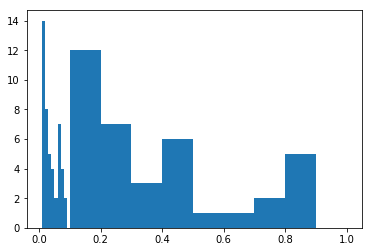

In [391]:
print( "Min: ", uuv.min(), " Max: ", uuv.max() )
p_bins = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07,0.08,0.09,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.hist( ppv, bins=p_bins)

In [388]:
remove_test()

x:  5.668922209671568  y:  5.312236427771378  z:  4.744981890781069  o:  24
Umove:  187.5366413607159  Vmove:  -945.0729766084535
Pcorr:  0.6618251250000001
pa_remove:  0.0573936877248


(0.057393687724757017, 187.5366413607159)

In [233]:
# Define Simulation Properties
Nh_max = 1000
seed = 1731
tailcor = True
N_moves = 100
N_equil = 500
N_prod = 1000
pi_move = 0.5
s_box = 10 #[A]
delta = 1

In [234]:
# Define Useful Constants
s_hh = 2.958 # sigma [A]
e_hh = 36.7 # eps over kb[K]
s_me = 3.73 # [A]
e_me = 147.5 #[K]
s_hc = 3.216 # sigma [A]
e_hc = 41.924 # eps over kb[K]
kb = 1.3806*10**(7) #[Pa*A^3/K]
c_bond = 2.24 #[A]

In [235]:
# Define System Properties
Pid = 40*10**(6) #[Pa]
T = 76.7 #[K]

In [236]:
# Computed Properties
Vol = s_box**3 #[A^3]
beta = 1/T #[K^-1]
Nh = floor( Pid*Vol*beta/kb )
rc = s_box
rc = min([2.5*s_hh,0.5*s_box]) #[A]
ZZ = beta*Pid
UT = 0
VirT = 0

Equlibration
0.0% Completed
	Delta: 0.9090909090909091
	Move acceptance: 20 out of 44 attempts.
	Add acceptance:  4 out of 34 attempts.
	Rem acceptance:  16 out of 22 attempts.
10.0% Completed
	Delta: 1.3168600901646978
	Move acceptance: 1184 out of 2502 attempts.
	Add acceptance:  74 out of 1208 attempts.
	Rem acceptance:  74 out of 1290 attempts.
20.0% Completed
	Delta: 0.9558108058943325
	Move acceptance: 1241 out of 2396 attempts.
	Add acceptance:  33 out of 1313 attempts.
	Rem acceptance:  32 out of 1291 attempts.
30.0% Completed
	Delta: 1.3895103959183832
	Move acceptance: 1333 out of 2527 attempts.
	Add acceptance:  28 out of 1231 attempts.
	Rem acceptance:  28 out of 1242 attempts.
40.0% Completed
	Delta: 2.00595747042818
	Move acceptance: 1295 out of 2555 attempts.
	Add acceptance:  39 out of 1152 attempts.
	Rem acceptance:  41 out of 1293 attempts.
50.0% Completed
	Delta: 1.487002743698108
	Move acceptance: 1251 out of 2494 attempts.
	Add acceptance:  50 out of 1245 attempts.

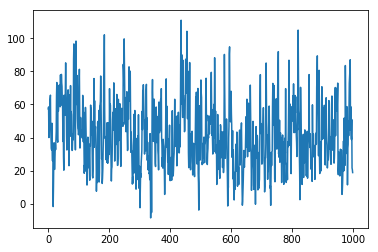

In [237]:
rhov, Env, Pv, Nv = mc_run()
print("avg P: ", Pv.mean(), " stdev: ", Pv.std() )
print("avg N: ", Nv.mean(), " stdev: ", Nv.std() )

Equlibration
0.0% Completed
	Delta: 1.2023299625209993
	Move acceptance: 29 out of 51 attempts.
	Add acceptance:  5 out of 23 attempts.
	Rem acceptance:  12 out of 26 attempts.
10.0% Completed
	Delta: 0.9625174305881976
	Move acceptance: 1214 out of 2507 attempts.
	Add acceptance:  51 out of 1245 attempts.
	Rem acceptance:  43 out of 1248 attempts.
20.0% Completed
	Delta: 1.0248948307675352
	Move acceptance: 1211 out of 2521 attempts.
	Add acceptance:  48 out of 1274 attempts.
	Rem acceptance:  49 out of 1205 attempts.
30.0% Completed
	Delta: 0.7877634066005238
	Move acceptance: 1170 out of 2415 attempts.
	Add acceptance:  33 out of 1316 attempts.
	Rem acceptance:  30 out of 1269 attempts.
40.0% Completed
	Delta: 1.324634780241161
	Move acceptance: 1288 out of 2490 attempts.
	Add acceptance:  40 out of 1259 attempts.
	Rem acceptance:  42 out of 1251 attempts.
50.0% Completed
	Delta: 0.897054592081079
	Move acceptance: 1260 out of 2514 attempts.
	Add acceptance:  49 out of 1254 attempts

(0.61845885640621512, 1.9933397378532973)

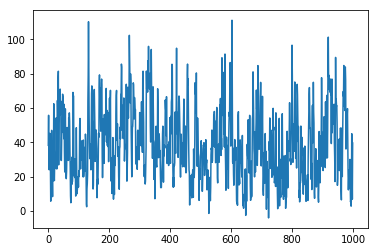

In [245]:
mc_grand( 2, 2 )
# Pid = 1   rho*:  0.620741372517  P*:  2.06962054051
# Pid = 2   

Equlibration
0.0% Completed
	Delta: 1.2988794281156701
	Move acceptance: 26 out of 54 attempts.
	Add acceptance:  5 out of 21 attempts.
	Rem acceptance:  17 out of 25 attempts.
10.0% Completed
	Delta: 1.1385504343896422
	Move acceptance: 1245 out of 2501 attempts.
	Add acceptance:  49 out of 1235 attempts.
	Rem acceptance:  40 out of 1264 attempts.
20.0% Completed
	Delta: 1.1679991434696624
	Move acceptance: 1246 out of 2474 attempts.
	Add acceptance:  28 out of 1254 attempts.
	Rem acceptance:  23 out of 1272 attempts.
30.0% Completed
	Delta: 1.319768847065994
	Move acceptance: 1280 out of 2483 attempts.
	Add acceptance:  32 out of 1251 attempts.
	Rem acceptance:  38 out of 1266 attempts.
40.0% Completed
	Delta: 1.0373638238332412
	Move acceptance: 1178 out of 2472 attempts.
	Add acceptance:  52 out of 1249 attempts.
	Rem acceptance:  51 out of 1279 attempts.
50.0% Completed
	Delta: 0.9223229450183232
	Move acceptance: 1229 out of 2514 attempts.
	Add acceptance:  49 out of 1198 attempt

30.0% Completed
	Delta: 1.2626819841851746
	Move acceptance: 1261 out of 2441 attempts.
	Add acceptance:  58 out of 1262 attempts.
	Rem acceptance:  61 out of 1297 attempts.
40.0% Completed
	Delta: 1.0626718030107354
	Move acceptance: 1182 out of 2495 attempts.
	Add acceptance:  43 out of 1265 attempts.
	Rem acceptance:  37 out of 1240 attempts.
50.0% Completed
	Delta: 1.08810378850863
	Move acceptance: 1293 out of 2515 attempts.
	Add acceptance:  38 out of 1244 attempts.
	Rem acceptance:  38 out of 1241 attempts.
60.0% Completed
	Delta: 1.172009834393377
	Move acceptance: 1237 out of 2509 attempts.
	Add acceptance:  36 out of 1231 attempts.
	Rem acceptance:  42 out of 1260 attempts.
70.0% Completed
	Delta: 0.9482155231965804
	Move acceptance: 1213 out of 2480 attempts.
	Add acceptance:  38 out of 1257 attempts.
	Rem acceptance:  35 out of 1263 attempts.
80.0% Completed
	Delta: 1.3359156501067422
	Move acceptance: 1263 out of 2534 attempts.
	Add acceptance:  43 out of 1214 attempts.
	R

60.0% Completed
	Delta: 1.1044843841743868
	Move acceptance: 1229 out of 2476 attempts.
	Add acceptance:  50 out of 1278 attempts.
	Rem acceptance:  50 out of 1246 attempts.
70.0% Completed
	Delta: 0.6203019502906083
	Move acceptance: 1191 out of 2498 attempts.
	Add acceptance:  40 out of 1262 attempts.
	Rem acceptance:  39 out of 1240 attempts.
80.0% Completed
	Delta: 0.9292008705179723
	Move acceptance: 1221 out of 2583 attempts.
	Add acceptance:  36 out of 1217 attempts.
	Rem acceptance:  35 out of 1200 attempts.
90.0% Completed
	Delta: 1.4931268751112177
	Move acceptance: 1230 out of 2500 attempts.
	Add acceptance:  38 out of 1258 attempts.
	Rem acceptance:  39 out of 1242 attempts.
Production
0.0% Completed
10.0% Completed
20.0% Completed
30.0% Completed
40.0% Completed
50.0% Completed
60.0% Completed
70.0% Completed
80.0% Completed
90.0% Completed
rho*:  0.61460660901  P*:  1.83882177951
Equlibration
0.0% Completed
	Delta: 1.5841854171929737
	Move acceptance: 31 out of 51 attempt

90.0% Completed
	Delta: 0.934447889259157
	Move acceptance: 1237 out of 2476 attempts.
	Add acceptance:  50 out of 1284 attempts.
	Rem acceptance:  50 out of 1240 attempts.
Production
0.0% Completed
10.0% Completed
20.0% Completed
30.0% Completed
40.0% Completed
50.0% Completed
60.0% Completed
70.0% Completed
80.0% Completed
90.0% Completed
rho*:  0.622941325679  P*:  2.00321394971


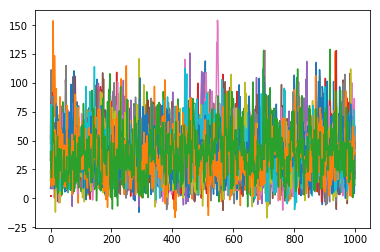

In [238]:
Pid_in = np.array( [0.016, 0.032, 0.064, 0.128, 0.25, 0.50, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0] )
rho_out = np.zeros( len( Pid_in ) )
P_out = np.zeros( len( Pid_in ))

for k in range( len(Pid_in) ):
    rho, P = mc_grand( Pid_in[k], 2)
    rho_out[k] = rho
    P_out[k] = P
    
plt.plot( rho_out, P_out )

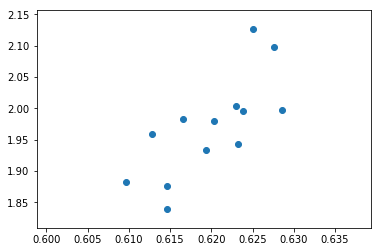

In [242]:
plt.scatter( rho_out, P_out )

In [226]:
P_out[4]

0.0

In [155]:
def move_test():
    o = floor( random()*Nh )
    x = X[o]
    y = Y[o]
    z = Z[o]
    print("x: ", x, " y: ", y," z: ", z," o: ", o )

    # Calculate Energy of current configuration
    U1, V1 = Up( x,y,z, o)
    print("U1: ", U1, "V1: ", V1 )

    # Calculate new Location
    xn = x + delta*(random()-0.5)
    yn = y + delta*(random()-0.5)
    zn = z + delta*(random()-0.5)
    print("xn: ", xn," yn: ", yn,"zn: ", zn)
    xn, yn, zn = box_fix( xn, yn, zn )
    print("xn: ", xn," yn: ", yn,"zn: ", zn)

    # Calculate Energy of New Configuration
    U2, V2 = Up( xn,yn,zn, o)
    print("U2: ", U2, " V2: ", V2 )
    U_move = U2 - U1
    V_move = V2 - V1
    print("Umove: ", U_move, " Vmove: ", V_move )

    if (U_move*beta > 100):
        pa_move = 0
    elif (U_move*beta < -100):
        pa_move = 1
    else:
        pa_move = p_move( U_move )
    print("pa_move: ", pa_move )

In [201]:
def add_test(x=-1.0, y=-1.0, z=-1.0):
    if ( x<0.0 and y<0.0 and z<0.0):
        x = random()*s_box
        y = random()*s_box
        z = random()*s_box

    print( "x: ", x, " y: ", y, " z: ", z)
    #Calculate Energy of Trial Move
    U_move, Vir_move = Up(x,y,z,Nh+1)
    print("Umove: ", U_move, " Vmove: ", Vir_move )
    print( )

    # Probability of accepting trial move
    if (U_move*beta > 100):
        pa_add = 0
    elif (U_move*beta < -100):
        pa_add = 1
    else:
        pa_add = p_add( U_move )
    print("pa_add: ", pa_add )

In [202]:
def remove_test(o=-1):
    if (o==-1):
        o = floor( random()*Nh )
        
    x = X[o]
    y = Y[o]
    z = Z[o]
    print("x: ", x, " y: ", y," z: ", z," o: ", o )

    # Calculate Energy of Trial Move
    U_move, Vir_move = Up( x,y,z, o)
    U_move = -U_move
    Vir_move = -Vir_move

    print("Umove: ", U_move, " Vmove: ", V_move )

    # Probability of Accepting Trial Move
    if (U_move*beta > 100):
        pa_remove = 0
    elif (U_move*beta < -100):
        pa_remove = 1
    else:
        pa_remove = p_rem(U_move)

    print("pa_remove: ", pa_remove)

In [267]:
remove_test()

x:  0.32589373696957624  y:  2.3501652245385847  z:  7.76368855796772  o:  23
Umove:  291.06545527859817  Vmove:  -16.934049828969393
Pcorr:  0.6618251250000001
pa_remove:  0.0148818947758


In [215]:
xt = X[2]
yt = Y[2]
zt = Z[2]
remove( 2 )
add_test(xt, yt, zt)

x:  1.138041092955976  y:  1.138041092955976  z:  1.4095708560503815
Umove:  22981.155351973604  Vmove:  295085.3615157379
pa_add:  0


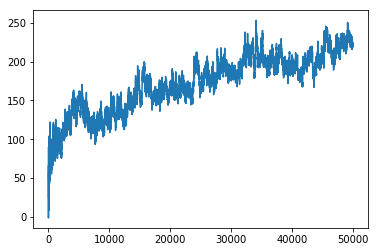

In [31]:
plt.plot( Pv )

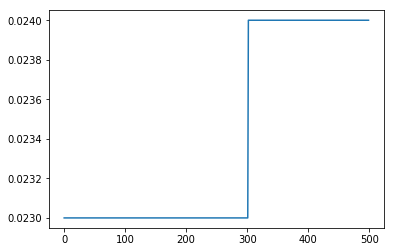

In [24]:
plt.plot( rhov )

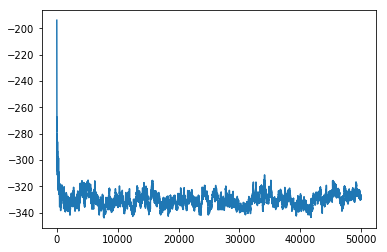

In [33]:
plt.plot( Env )

In [10]:
floor( Pid*Vol*beta/kb )

38

In [54]:
beta

0.02724795640326975

In [74]:
Nh = floor( Pid*Vol*beta/kb )

def p_rem( U_move ):
    return Nh*kb*np.exp( -beta*U_move )/(ZZ*Vol)
def p_add( U_move ):
    return ZZ*Vol*np.exp( -beta*U_move )/(Nh + 1)/kb
def p_move( U_move ):
    return np.exp( -beta*U_move)

Uv = np.linspace(-50, 50, 10000)
pv_rem = np.zeros( len(Uv) )
pv_add = np.zeros( len(Uv) )
pv_move= np.zeros( len(Uv) )

for i in range(len(Uv)):
    pv_rem[i] = p_rem( Uv[i])
    pv_add[i] = p_add( Uv[i])
    pv_move[i]= p_move(Uv[i])
    

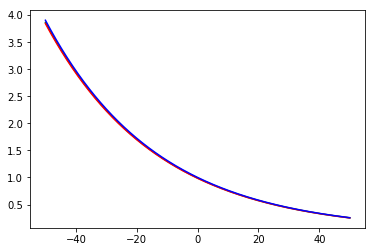

In [75]:
plt.plot( Uv, pv_add, 'g-' )
plt.plot( Uv, pv_rem, 'r-' )
plt.plot( Uv, pv_move,'b-' )

In [216]:
Nh = 43
Ratt = Ratt + 1

# Select Random particle
o = floor( random()*Nh )
x = X[o]
y = Y[o]
z = Z[o]

# Calculate Energy of Trial Move
U_move, Vir_move = Up( x,y,z, o)
U_move = -U_move
Vir_move = -Vir_move
if tailcor:
    U_move = U_move + ((Nh-1)*Ucor(rc,(Nh-1)/Vol)-Nh*Ucor(rc,Nh/Vol))

# Probability of Accepting Trial Move
if (U_move*beta > 100):
    pa_remove = 0
elif (U_move*beta < -100):
    pa_remove = 1
else:
    pa_remove = Nh*kb*np.exp( -beta*U_move )/(ZZ*Vol)

# Accept or Decline Trial Move
print( U_move )
print( pa_remove )

ZeroDivisionError: float division by zero

In [234]:
jb = 0
ia = o
En_move = 0
Vir_move = 0
for i in range(jb, Nh):
    if ( i != ia):
        print( i )
        r2 = dist_hi( x,y,z, i)
        ui, viri = Ui( r2, e_hh, s_hh)
        En_move = En_move + ui
        Vir_move = Vir_move + viri
#print( En_move, Vir_move)
for ic in range(Nc):
    r2 = dist_ci( x,y,z, ic)
    ui, viri = Ui( r2, e_hc, s_hc)
    En_move = En_move + ui
    Vir_move = Vir_move + viri

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
37


ZeroDivisionError: float division by zero

In [223]:
dist_hi( x, y, z, o)

0.0

In [239]:
Nh

43

In [238]:
X

[7.191730627794675,
 0.9308048144714198,
 2.220687397197388,
 0.08663601607553106,
 5.17750709053088,
 8.314576908376985,
 2.720391336290822,
 8.794568928071948,
 4.881118580801072,
 1.8502371719297228,
 7.365322898423499,
 0.3416601306921989,
 3.8966324871326696,
 1.9612181599020249,
 2.2184944009586998,
 7.933298514922722,
 8.169071786162668,
 1.9973906453317927,
 5.504972238911279,
 7.841203096660036,
 8.223005395008482,
 9.773446549221891,
 0.7787098007387621,
 6.898284002501248,
 2.708243535372861,
 9.613348051181642,
 9.64139488216892,
 3.870829181674648,
 3.9048850885738826,
 8.198095555689056,
 6.858267307794913,
 8.417620653864349,
 3.996357459466603,
 9.564298713211745,
 6.543249789114158,
 9.046025923149719,
 0.9047155380724325,
 0.9047155380724325,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [229]:
r2

NameError: name 'r2' is not defined

In [34]:
p_rem(-0.1)

0.62338979464536803

In [35]:
p_move(0)

1.0